In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

In [ ]:
data=pd.read_csv(r'/content/Electric_Production.csv')

In [ ]:
data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [ ]:
type(data['DATE'][0])

str

In [ ]:
data['DATE']=pd.to_datetime(data['DATE'])

In [ ]:
data

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [ ]:
data.isna().sum()

DATE          0
IPG2211A2N    0
dtype: int64

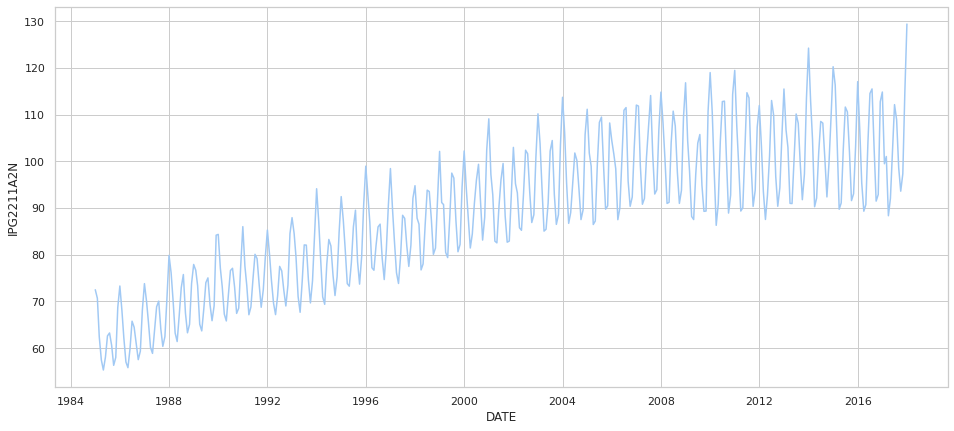

In [ ]:

plt.figure(figsize=(16,7))
sns.set_theme(style="whitegrid", palette="pastel")
sns.lineplot(x=data['DATE'],y=data['IPG2211A2N']);
plt.show()

Data shows a seasonality and also an upward trend. Hence, data is stationary.



In [ ]:
len(data)

397

In [ ]:
data=data.set_index('DATE')

In [ ]:
train=data.iloc[:round(0.70*len(data))]
test=data.iloc[round(0.70*len(data)):]

In [ ]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
window_size = 6
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import keras

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(train_set,epochs=50)

Epoch 1/50
9/9 [==============================] - 2s 15ms/step - loss: 2672.8149
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 222.6226
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 62.7580
Epoch 4/50
9/9 [==============================] - 0s 11ms/step - loss: 52.3768
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 45.6402
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 40.5940
Epoch 7/50
9/9 [==============================] - 0s 9ms/step - loss: 39.6487
Epoch 8/50
9/9 [==============================] - 0s 10ms/step - loss: 38.3524
Epoch 9/50
9/9 [==============================] - 0s 8ms/step - loss: 36.7587
Epoch 10/50
9/9 [==============================] - 0s 8ms/step - loss: 36.1296
Epoch 11/50
9/9 [==============================] - 0s 10ms/step - loss: 34.9172
Epoch 12/50
9/9 [==============================] - 0s 8ms/step - loss: 33.0742
Epoch 13/50
9/9 [==============================] - 0s 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


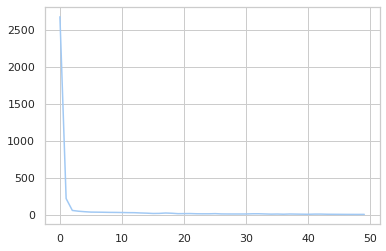

In [ ]:
loss=model.history.history['loss']
sns.lineplot(range(len(loss)),loss);

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
# Reduce the original series
forecast_series = data['IPG2211A2N'][round(0.70*len(data))-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
#plot_series(time_valid, (x_valid, results))

In [ ]:
results

array([100.21111 ,  93.353294,  95.96028 , 101.072014, 114.58997 ,
       108.15716 ,  99.27233 ,  91.01293 ,  95.40851 , 105.884186,
       116.700325, 108.66156 ,  96.48826 ,  91.81052 ,  96.82641 ,
        93.112144, 106.30752 , 103.6874  ,  97.60351 ,  88.33967 ,
        90.965744, 100.85458 , 116.73736 , 107.94054 ,  97.84327 ,
        89.15698 ,  93.572266, 100.09521 , 114.1999  , 108.55169 ,
        99.414406,  90.222206,  91.5686  , 107.707695, 123.50947 ,
       111.76827 ,  97.87882 ,  90.41433 ,  99.016335,  95.79559 ,
       113.0451  , 109.444496, 100.8389  ,  90.45193 ,  92.526955,
       108.58906 , 117.03148 , 109.340904,  96.54064 ,  89.96667 ,
        97.90881 , 102.70194 , 107.23881 , 105.303604,  97.156456,
        89.37653 ,  95.71515 , 108.111725, 112.96623 , 109.26282 ,
        97.35964 ,  93.87449 ,  93.945724, 100.988014, 111.39042 ,
       109.051735, 100.64858 ,  91.71801 ,  93.55637 , 111.02096 ,
       118.09001 , 111.626396, 100.79176 ,  94.33512 ,  96.778

In [ ]:
len(results)

119

In [ ]:
test['preds']=results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,IPG2211A2N,preds
DATE,,
2008-03-01,100.4386,100.211113
2008-04-01,90.9944,93.353294
2008-05-01,91.2348,95.960281
2008-06-01,103.9581,101.072014
2008-07-01,110.7631,114.589973
...,...,...
2017-09-01,98.6154,99.449036
2017-10-01,93.6137,90.565086
2017-11-01,97.3359,96.971664


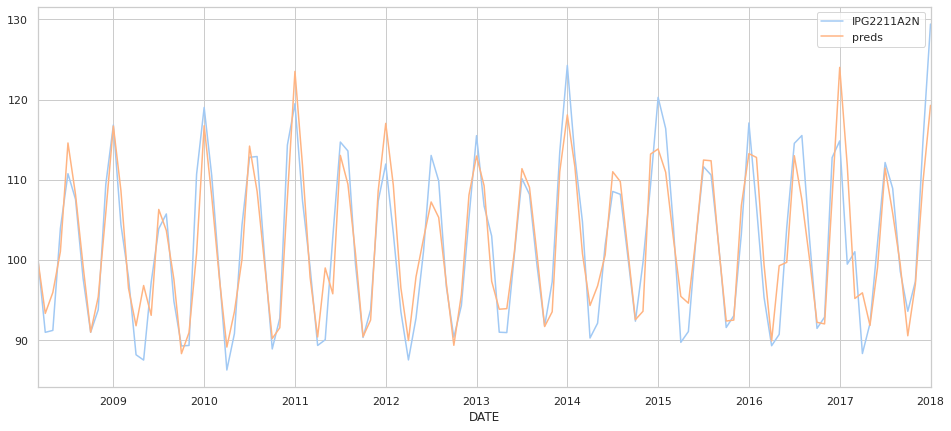

In [ ]:
test.plot(figsize=(16,7))

In [ ]:
print(keras.metrics.mean_squared_error(test['IPG2211A2N'],test['preds']))

tf.Tensor(16.142046, shape=(), dtype=float32)


In [ ]:
print(keras.metrics.mean_absolute_error(test['IPG2211A2N'],test['preds']))

tf.Tensor(3.1162796, shape=(), dtype=float32)


**Increasing number of layers/hyperparameter tuning**

In [ ]:
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(window_size,1)))
#model.add(LSTM(64))
model1.add(Dense(32,activation='relu'))
model1.add(Dense(16,activation='relu'))
#model.add(Dense(8,activation='relu'))
model1.add(Dense(1))

#model1.compile(optimizer='adam', loss='mse')

In [ ]:
import tensorflow as tf
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

In [ ]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model1.compile(loss="mse", optimizer=optimizer)

In [ ]:
history=model.fit(train_set,epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 9ms/step - loss: 11.2129
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 15.9664
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 13.8031
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 12.3899
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 10.8431
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 10.7595
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 10.2559
Epoch 8/100
9/9 [==============================] - 0s 8ms/step - loss: 9.8159
Epoch 9/100
9/9 [==============================] - 0s 8ms/step - loss: 11.1454
Epoch 10/100
9/9 [==============================] - 0s 8ms/step - loss: 10.2928
Epoch 11/100
9/9 [==============================] - 0s 8ms/step - loss: 9.5481
Epoch 12/100
9/9 [==============================] - 0s 8ms/step - loss: 8.9971
Epoch 13/100
9/9 [==============================] - 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


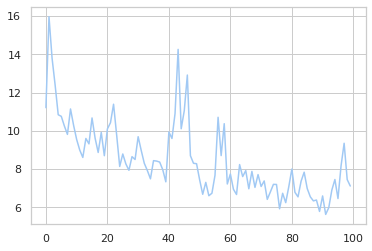

In [ ]:
loss=history.history['loss']
sns.lineplot(range(len(loss)),loss);

In [ ]:
# Reduce the original series
forecast_series = data['IPG2211A2N'][round(0.70*len(data))-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
#plot_series(time_valid, (x_valid, results))

In [ ]:
print(keras.metrics.mean_squared_error(test['IPG2211A2N'],results))

tf.Tensor(11.173402, shape=(), dtype=float32)


In [ ]:
results

array([100.54289 ,  90.85103 ,  93.907486, 103.34893 , 112.90198 ,
       108.67207 ,  99.23299 ,  88.865616,  93.26721 , 106.82065 ,
       116.85106 , 107.70955 ,  97.77893 ,  89.930115,  92.01425 ,
        96.35082 , 107.52575 , 105.83194 ,  97.09482 ,  86.65332 ,
        89.37955 , 101.42786 , 116.2336  , 106.74948 ,  98.882935,
        88.29648 ,  90.72272 , 101.354965, 113.02324 , 107.78893 ,
        99.011314,  88.0585  ,  91.677734, 108.10102 , 118.444176,
       109.76028 ,  99.511795,  89.44469 ,  93.52982 ,  99.14556 ,
       112.23875 , 109.86971 , 100.65457 ,  88.91275 ,  92.26288 ,
       108.47305 , 115.2626  , 108.612144,  97.17253 ,  88.71437 ,
        94.754265, 103.90259 , 110.05076 , 105.42914 ,  96.7152  ,
        88.10854 ,  93.53609 , 107.79554 , 113.95947 , 108.99667 ,
        97.72017 ,  90.48363 ,  92.851105, 104.130264, 110.66876 ,
       111.3134  , 100.33522 ,  89.28902 ,  91.77697 , 111.66581 ,
       119.96922 , 110.68782 , 101.67993 ,  92.547325,  93.983

In [ ]:
test['preds1']=results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,IPG2211A2N,preds,preds1
DATE,,,
2008-03-01,100.4386,100.211113,100.542892
2008-04-01,90.9944,93.353294,90.851028
2008-05-01,91.2348,95.960281,93.907486
2008-06-01,103.9581,101.072014,103.348930
2008-07-01,110.7631,114.589973,112.901978
...,...,...,...
2017-09-01,98.6154,99.449036,99.226974
2017-10-01,93.6137,90.565086,88.452721
2017-11-01,97.3359,96.971664,94.067444


In [ ]:
print(tf.keras.metrics.mean_squared_error(test['IPG2211A2N'], results).numpy())
print(tf.keras.metrics.mean_absolute_error(test['IPG2211A2N'], results).numpy())

11.173402
2.655865


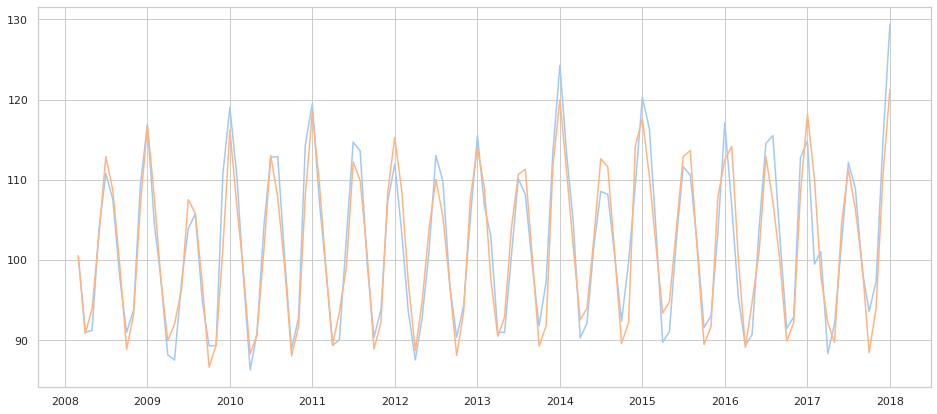

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(test['IPG2211A2N']);
plt.plot(test['preds1']);


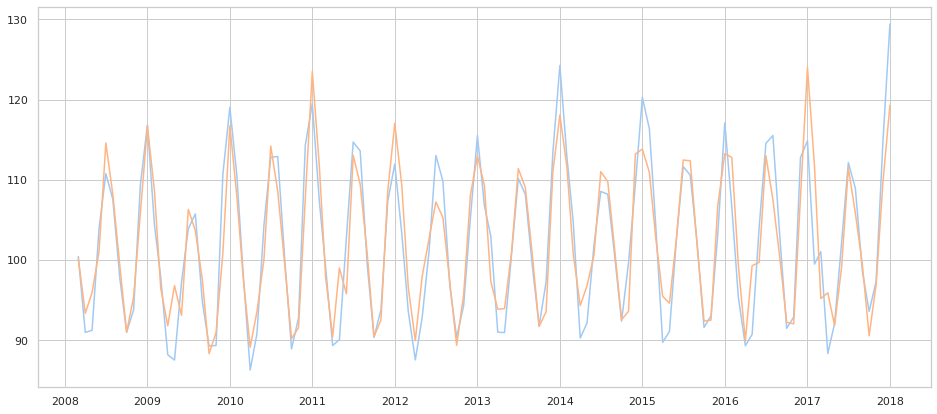

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(test['IPG2211A2N']);
plt.plot(test['preds']);


In [ ]:
model2 = tf.keras.models.Sequential([
  
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
#model2.summary()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model2.fit(train_set, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
9/9 [==============================] - 4s 12ms/step - loss: 10.7970 - lr: 1.0000e-08
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 10.7970 - lr: 1.1220e-08
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 10.7970 - lr: 1.2589e-08
Epoch 4/50
9/9 [==============================] - 0s 11ms/step - loss: 10.7970 - lr: 1.4125e-08
Epoch 5/50
9/9 [==============================] - 0s 9ms/step - loss: 10.7971 - lr: 1.5849e-08
Epoch 6/50
9/9 [==============================] - 0s 10ms/step - loss: 10.7970 - lr: 1.7783e-08
Epoch 7/50
9/9 [==============================] - 0s 10ms/step - loss: 10.7970 - lr: 1.9953e-08
Epoch 8/50
9/9 [==============================] - 0s 10ms/step - loss: 10.7970 - lr: 2.2387e-08
Epoch 9/50
9/9 [==============================] - 0s 10ms/step - loss: 10.7972 - lr: 2.5119e-08
Epoch 10/50
9/9 [==============================] - 0s 10ms/step - loss: 10.7971 - lr: 2.8184e-08
Epoch 11/50
9/9 [=======================

In [ ]:
forecast_series = data['IPG2211A2N'][round(0.70*len(data))-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model2, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()


In [ ]:
test['preds2']=results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
print(tf.keras.metrics.mean_squared_error(test['IPG2211A2N'], results).numpy())
print(tf.keras.metrics.mean_absolute_error(test['IPG2211A2N'], results).numpy())

434.81384
18.46969


In [ ]:
forecast_series = data['IPG2211A2N'][round(0.70*len(data))-window_size:-1]


In [ ]:
forecast_series

DATE
2007-09-01    101.5316
2007-10-01     93.0068
2007-11-01     93.9126
2007-12-01    106.7528
2008-01-01    114.8331
                ...   
2017-08-01    108.9312
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
Name: IPG2211A2N, Length: 124, dtype: float64

In [ ]:
data['IPG2211A2N']

DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Name: IPG2211A2N, Length: 397, dtype: float64

At this point, the model seems to be overfitting by adding more LSTM layers/modifying learning rates. Thus, the second model with final mse 11.17 and mae 2.1 can be finalized.